# Predicting house prices with XGBoost

This notebook uses XGBoost to predict house prices. XGBoost (eXtreme Gradient Boosting) is a powerful ML algorithm, popular for its speed and performance. It's an implementation of gradient boosted decision trees designed for efficiency and scalability. 

__Key Concepts__:

__Boosting__ - XGBoost is based on the boosting ensemble technique, whcih builds models sequentially. Each new model attempts to correct the errors of the previous one, thereby reducing the voerall error.  

__Decision trees__ - XGBoost builds an ensemble of decision trees. Each tree is a sequence of binary splits based on feature values, helping the model to make predictions.

__Gradient boosting__ - 'gradient' refers to the use of gradient descent to minimise the loss function. In XGBoost this means the model is trained to minimise the difference between the predicted and actual values.

__Key Parameters__:

* n_estimators - no. of trees to build.
* learning_rate - step size shrinkage, controlling how much each tree contributes to the final predictions.
* max_depth - max depth of each tree, controlling model complexity.
* subsample - proportion of samples used for each tree, reducing overfitting.
* colsample_bytree - fraction of features used for each tree, helps prevent overfitting.
* gamma - minimum loss reduction required to make a further partition, acting as a regularisation parameter.

## Notebook setup

This notebook was developed with the following versions:

Python = 3.12.6  

matplotlib = 3.9.2  
numpy = 2.1.1   
pandas = 2.2.3  
scikit-learn = 1.5.2  
xgboost = 2.1.1  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor

## Prep dataset

In [2]:
# Load dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
# Fit only on the training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data
X_test_scaled = scaler.transform(X_test)

## Train XGBoost model

In [4]:
# Convert the data into DMatrix format
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [5]:
# Set the parameters for regression
params = {
    'objective': 'reg:squarederror',  # Regression with squared loss
    'eval_metric': 'rmse',            # Root Mean Squared Error
    'learning_rate': 0.1,
    'max_depth': 6,
    'seed': 42
}

In [6]:
# Specify validations set to watch performance
evallist = [(dtest, 'eval'), (dtrain, 'train')]

# Train the model
num_round = 100
bst = xgb.train(
    params,
    dtrain,
    num_round,
    evallist,
    early_stopping_rounds=10,
    verbose_eval=10
)

[0]	eval-rmse:1.07228	train-rmse:1.07996
[10]	eval-rmse:0.69252	train-rmse:0.66784
[20]	eval-rmse:0.58760	train-rmse:0.54251
[30]	eval-rmse:0.54267	train-rmse:0.48550
[40]	eval-rmse:0.51444	train-rmse:0.44916
[50]	eval-rmse:0.50369	train-rmse:0.42916


/Users/jackwalker/anaconda3/envs/xgboost/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[60]	eval-rmse:0.49680	train-rmse:0.41414
[70]	eval-rmse:0.48815	train-rmse:0.39860
[80]	eval-rmse:0.48381	train-rmse:0.38878
[90]	eval-rmse:0.47944	train-rmse:0.37753
[99]	eval-rmse:0.47672	train-rmse:0.36895


## Evalute model

In [7]:
# Make predictions
y_pred = bst.predict(dtest)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.4767


## Visualisations

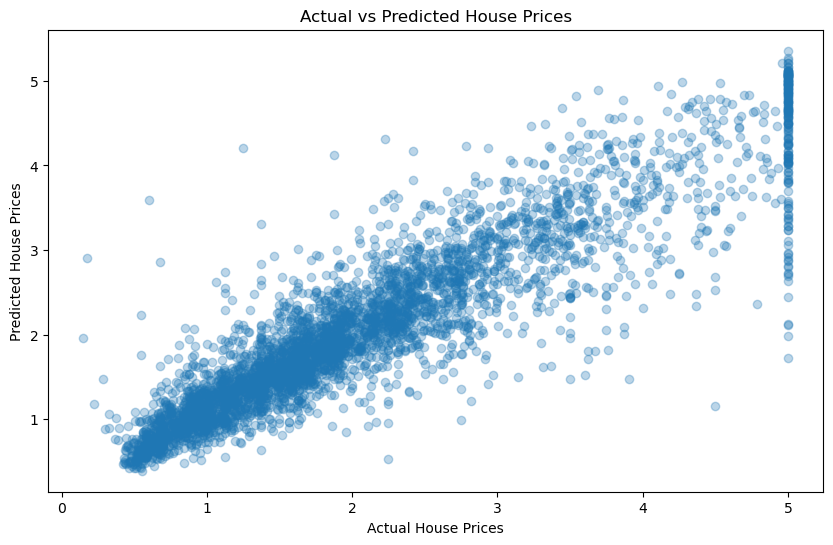

In [8]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()


## Model tuning

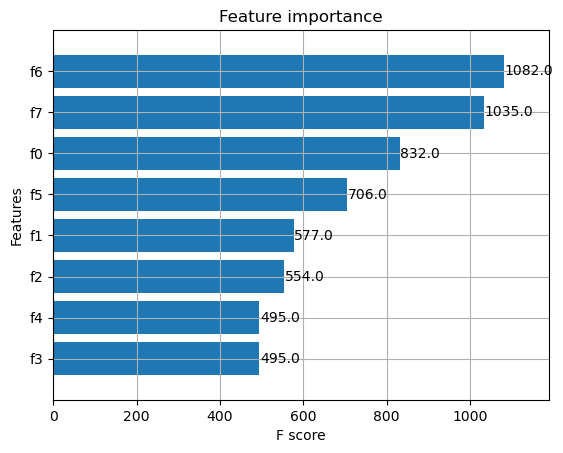

In [9]:
# Plot feature importance
xgb.plot_importance(bst, height=0.8, max_num_features=10)
plt.show()

In [10]:
# Define the model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    seed=42
)

# Define the grid of hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1]
}

# Set up the grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


## Evaluate tuned model

In [12]:
# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

# Calculate RMSE
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
print(f"Tuned Test RMSE: {rmse_tuned:.4f}")

Tuned Test RMSE: 0.4613


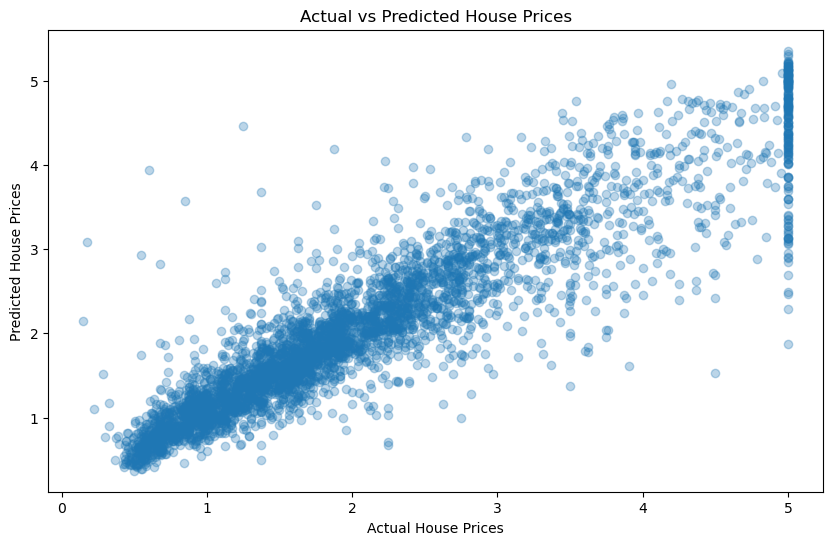

In [13]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.3)
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()